In [1]:
import random
import folium
from folium.plugins import HeatMap
from folium.map import Popup
import matplotlib.pyplot as plt
from random import sample
from skopt import gp_minimize
from skopt.space import Categorical
import math
import time
from statistics import mean, median
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../code/')

import mbrs_functions
import circles_functions
import grid_functions

%load_ext autoreload
%autoreload 2

## Plot functions

In [9]:
# Method for creating performance plots to compare methods against all parameters
def box_plots():

    for entropy_mode in entropy_modes:
        print('# entropy_mode: ' + entropy_mode)

        # iterate over each variable to be studied
        for variable in variables.keys():
            if len(variables[variable]['range']) <=1:
                continue
            print('##', variable)

            # initialize results
            results_df = dict()
            results = dict()
            results['region'] = dict()
            results['score'] = dict()
            for method in methods:
                results['region'][method['label']] = []
                results['score'][method['label']] = []
            results['region'][variable] = []
            results['score'][variable] = []


            for other_variable in variables.keys():
                if other_variable == variable:
                    continue
                params['variables'][other_variable]['current'] = variables[other_variable]['default']

            # prepare the map
            marker_size = 20
            m = folium.Map(location=map_settings['location'], zoom_start=map_settings['zoom'], tiles=map_settings['tiles'])

            # iterate over the values of the current variable and create the plots for time and score
            for value in variables[variable]['range']:
                params['variables'][variable]['current'] = value

                for var in params['variables']:
                    print(var + ':' + str(params['variables'][var]['current']))

                G = G_dict[str(params['variables']['eps']['current'])]
                rtree = rtree_dict[str(params['variables']['eps']['current'])]

                for method in methods:
                    print('Run method: ' + method['label'])
                    params['methods']['current'] = method['name']
                    params['entropy_mode']['current'] = entropy_mode

                    # execute the method

                    mean_score = 0
                    mean_elapsed = 0
                    n_repeats = 3
                    for i in range(n_repeats): ######## REPEAT and take mean
                        start_time = time.time()
                        if method['name'] == 'ExpCircles':
                            seeds_circles = circles_functions.pickSeeds(df, method['config']['seeds_ratio'])
                            score, region, updates = circles_functions.run_method(df, types, G, rtree, seeds_circles, params, start_time)
                        elif method['name'] == 'ExpAll':
                            # seeds_exp_all = list(G.nodes)
                            seeds_exp_all = sample(list(G.nodes), int(method['config']['seeds_ratio'] * len(list(G.nodes))))
                            score, region, updates = mbrs_functions.run_method(df, G, rtree, types, params, start_time, seeds_exp_all)
                        elif method['name'] == 'ExpSingle':
                            seeds_exp_single = sample(list(G.nodes), int(method['config']['seeds_ratio'] * len(list(G.nodes))))
                            score, region, updates = mbrs_functions.run_method(df, G, rtree, types, params, start_time, seeds_exp_single)
                        elif method['name'] == 'ExpHybrid':
                            seeds_exp_single = sample(list(G.nodes), int(method['config']['seeds_ratio'] * len(list(G.nodes))))
                            score, region, updates = mbrs_functions.run_method(df, G, rtree, types, params, start_time, seeds_exp_single)
                        elif method['name'] == 'Grid-A':
                            params['grid'] = method['config']
                            params['grid']['top_mode'] = 'all'
                            score, region, updates, _ = grid_functions.run_method(df, G, rtree, types, params, start_time)
                        elif method['name'] == 'Grid-S':
                            params['grid'] = method['config']
                            params['grid']['top_mode'] = 'best'
                            score, region, updates, _ = grid_functions.run_method(df, G, rtree, types, params, start_time)
                        elif method['name'] == 'Grid2-A':
                            params['grid'] = method['config']
                            params['grid']['top_mode'] = 'all'
                            score, region, updates, _ = grid_functions.run_method_simple(df, G, rtree, types, params, start_time)
                        elif method['name'] == 'Grid2-S':
                            params['grid'] = method['config']
                            params['grid']['top_mode'] = 'best'
                            score, region, updates, _ = grid_functions.run_method_simple(df, G, rtree, types, params, start_time)
                        elapsed = time.time() - start_time

                        # if variable == 'time_budget':
                        #     idx = params['variables']['time_budget']['range'].index(params['variables']['time_budget']['current']) - 1
                        #     if idx >= 0 and elapsed < params['variables']['time_budget']['range'][idx]:
                        #         score = None

                        mean_score += score
                        mean_elapsed += elapsed

                    mean_score /= n_repeats
                    mean_elapsed /= n_repeats
                    score = mean_score
                    elapsed = mean_elapsed

                    results['score'][method['label']].append(score)
                    results['region'][method['label']].append(region)
                    print(score, elapsed)

                    # add region to map
                    feature_group = folium.FeatureGroup(name=method['label'] + '_' + variable + '_' + str(value))
                    for r in region:
                        folium.Circle(location=[df.iloc[r]['lat'], df.iloc[r]['lon']], radius=map_settings['marker_size'], popup=df.iloc[r]['cat1'], color=colors[df.iloc[r]['cat1']], fill=True, fill_color=colors[df.iloc[r]['cat1']], fill_opacity=1).add_to(feature_group)
                    feature_group.add_to(m)                

                results['score'][variable].append(value)
                results['region'][variable].append(value)

                print()

            # prepare the plots
            results_df['score'] = pd.DataFrame.from_dict(results['score'])
            results_df['score'].set_index(variable, inplace=True)
            results_df['region'] = pd.DataFrame.from_dict(results['region'])
            results_df['region'].set_index(variable, inplace=True)

            # save the plots
            fig = results_df['score'].plot(kind='bar', rot=1, ylabel='Score', ylim=(0.5, 1.0)).get_figure()
            fig.savefig(plots_dir + entropy_mode + '_' + variable + '_score.pdf')

            # save the results
            results_df['score'].to_csv(plots_dir + entropy_mode + '_' + variable + '_score.csv')
            results_df['region'].to_csv(plots_dir + entropy_mode + '_' + variable + '_region.csv')

            # save the map
            folium.LayerControl().add_to(m)
            m.save(plots_dir + entropy_mode + '_' + variable + '_map.html')

In [11]:
# Method for creating anytime plots for all methods within the specified time budget
def anytime():

    for entropy_mode in entropy_modes:
        print('# entropy_mode: ' + entropy_mode)

        # iterate over each variable to be studied
        for variable in variables.keys():

            print('##', variable)

            # initialize results
            results_df = dict()
            results = dict()
            results['region'] = dict()
            results['score'] = dict()
            for method in methods:
                results['region'][method['label']] = []
                results['score'][method['label']] = []
            results['region'][variable] = []
            results['score'][variable] = []


            for other_variable in variables.keys():
                if other_variable == variable:
                    continue
                params['variables'][other_variable]['current'] = variables[other_variable]['default']


            # iterate over the values of the current variable and create the plots for time and score
            for value in variables[variable]['range']:
                params['variables'][variable]['current'] = value

                for var in params['variables']:
                    print(var + ':' + str(params['variables'][var]['current']))

                G = G_dict[str(params['variables']['eps']['current'])]
                rtree = rtree_dict[str(params['variables']['eps']['current'])]


                updates_all = []

                for method in methods:
                    print('Run method: ' + method['name'] + ' ' + method['label'])
                    params['methods']['current'] = method['name']
                    params['entropy_mode']['current'] = entropy_mode

                    # execute the method

                    start_time = time.time()
                    if method['name'] == 'ExpCircles':
                        seeds_circles = circles_functions.pickSeeds(df, method['config']['seeds_ratio']) 
                        score, region, updates = circles_functions.run_method(df, types, G, rtree, seeds_circles, params, start_time)
                    elif method['name'] == 'ExpAll':
                        # seeds_exp_all = list(G.nodes)
                        seeds_exp_all = sample(list(G.nodes), int(method['config']['seeds_ratio'] * len(list(G.nodes))))
                        score, region, updates = mbrs_functions.run_method(df, G, rtree, types, params, start_time, seeds_exp_all)
                    elif method['name'] == 'ExpSingle':
                        seeds_exp_single = sample(list(G.nodes), int(method['config']['seeds_ratio'] * len(list(G.nodes))))
                        score, region, updates = mbrs_functions.run_method(df, G, rtree, types, params, start_time, seeds_exp_single)
                    elif method['name'] == 'ExpHybrid':
                        seeds_exp_single = sample(list(G.nodes), int(method['config']['seeds_ratio'] * len(list(G.nodes))))
                        score, region, updates = mbrs_functions.run_method(df, G, rtree, types, params, start_time, seeds_exp_single)
                    elif method['name'] == 'Grid-A':
                        params['grid'] = method['config']
                        params['grid']['top_mode'] = 'all'
                        score, region, updates, _ = grid_functions.run_method(df, G, rtree, types, params, start_time)
                    elif method['name'] == 'Grid-S':
                        params['grid'] = method['config']
                        params['grid']['top_mode'] = 'best'
                        score, region, updates, _ = grid_functions.run_method(df, G, rtree, types, params, start_time)
                    elif method['name'] == 'Grid2-A':
                        params['grid'] = method['config']
                        params['grid']['top_mode'] = 'all'
                        score, region, updates, _ = grid_functions.run_method_simple(df, G, rtree, types, params, start_time)
                    elif method['name'] == 'Grid2-S':
                        params['grid'] = method['config']
                        params['grid']['top_mode'] = 'best'
                        score, region, updates, _ = grid_functions.run_method_simple(df, G, rtree, types, params, start_time)
                    elapsed = time.time() - start_time

                    print(score, elapsed, list(updates.keys())[0], *list(updates.keys())[-2:])
                    updates_all.append(pd.DataFrame.from_dict(updates, orient='index', columns=[method['label']]))



                # create the plot
                i = 0
                styles = ['.--', 'x--', '+--', '*--', 'o--'] * 2
                ax = updates_all[0].plot(ylabel='Score', xlabel='Time (sec)', logx=False, style=styles[i])
                for updates in updates_all:
                    if i > 0:
                        fig = updates.plot(ax=ax, style=styles[i]).get_figure()
                        fig.show()
                    i += 1

                # save the figure
                fig.savefig(plots_dir + entropy_mode + '_' + prefix + variable + '_' + str(value) + '_anytime.pdf')

                # create the plot w log
                i = 0
                styles = ['.--', 'x--', '+--', '*--', 'o--'] * 2
                ax = updates_all[0].plot(ylabel='Score', xlabel='Time (sec)', logx=True, style=styles[i])
                for updates in updates_all:
                    if i > 0:
                        fig = updates.plot(ax=ax, style=styles[i]).get_figure()
                        fig.show()
                    i += 1

                # save the figure
                fig.savefig(plots_dir + entropy_mode + '_' + prefix + variable + '_' + str(value) + '_l_anytime.pdf')


                print()


# Load data

In [2]:
df, types, colors = mbrs_functions.load_data('../test/data/osmpois-nyc.csv')

# directory to save the plots
plots_dir = '../test/plots/nyc/'

# Contents in the input dataset
df

#types: 14
#points: 38843
global entropy: 2.059746366431755
max entropy: 2.6390573296152584


,id,name,lon,lat,cat1,cat2
0,N1000793154,Barnes & Noble,-73.978797,40.755823,shop,book
1,N1000798085,The Food Emporium,-73.986292,40.761717,shop,supermarket
2,N1001284305,Zara,-73.999624,40.722322,shop,clothes
3,N1002880708,Lombardi's Pizza,-73.995610,40.721558,eat/drink,restaurant
4,N1003286805,Union Square Green Market,-73.989670,40.736663,shop,marketplace
...,...,...,...,...,...,...
38838,W932542022,Ridgewood Community Garden,-73.909264,40.712948,landuse,park
38839,W932543441,The Garden of Resilience,-73.765591,40.663595,landuse,park
38840,W934137489,Hotel Central Times Square,-73.994123,40.754331,accommodation,hotel
38841,W935154519,Steinway Branch Queens Borough Public Library,-73.909418,40.776819,publicservice,library


# Settings for plotting maps

In [3]:
map_settings = {
    'location': [df.iloc[0]['lat'], df.iloc[0]['lon']],
    'zoom': 12,
    'tiles': 'Stamen toner',
    'marker_size': 20
}

# Set general parameters

In [4]:
entropy_modes = ['low', 'high']

variables = {
    'eps': {
        'range': [0.003], #[0.001, 0.002, 0.003], 
        'default': 0.003,
    },
    'max_size': {
        'range': [200], #[100, 200, 300],
        'default': 200,
    },
    'size_weight': {
        'range': [1], #[0, 0.5, 1, 2],
        'default': 1,
    },
    'time_budget': {
        'range': [],
        'default':20,
    },
}

settings = {
    'top_k': 1,
    'max_se': math.log(len(types))
}

In [5]:
## placeholder

params = {
    'variables': {
        'eps': {
            'current': None
        },
        'max_size': {
            'current': None
        },
        'size_weight': {
            'current': None
        },
        'time_budget': {
            'current': None
        }
    },
    'entropy_mode': {
        'current': None
    },
    'grid': {},
    'methods': {},
}

params['settings'] = settings


# Pre-process (create connectivity graphs and R-tree indices)

## Create graphs for various eps

In [6]:
G_dict = dict()
rtree_dict = dict()

for eps in variables['eps']['range']:
    print(eps)
    G, rtree = mbrs_functions.create_graph(df, eps)
    G_dict[str(eps)] = G
    rtree_dict[str(eps)] = rtree

0.003


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Max degree: 385 Mean degree: 80.39636485338414 Median degree: 58
Max connected component: 16032


# Parameter fine-tuning: Anytime plots with varying number of seeds per method

In [9]:
prefix = 'ExpCircles_'

methods = [
    {
        'name': 'ExpCircles',
        'label': '0.1',
        'config':{
            'seeds_ratio': 0.1
        }, 
    },
    {
        'name': 'ExpCircles',
        'label': '0.2',
        'config':{
            'seeds_ratio': 0.2
        }, 
    },
    {
        'name': 'ExpCircles',
        'label': '0.3',
        'config':{
            'seeds_ratio': 0.3
        }, 
    },
    {
        'name': 'ExpCircles',
        'label': '0.4',
        'config':{
            'seeds_ratio': 0.4
        }, 
    },
    {
        'name': 'ExpCircles',
        'label': '0.5',
        'config':{
            'seeds_ratio': 0.5
        }, 
    },
    {
        'name': 'ExpCircles',
        'label': '0.8',
        'config':{
            'seeds_ratio': 0.8
        }, 
    },
    {
        'name': 'ExpCircles',
        'label': '1.0',
        'config':{
            'seeds_ratio': 1
        }, 
    },
]



# entropy_mode: low
## eps
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: ExpCircles 0.1
0.6798114222282985 20.008130073547363 0.002098560333251953 10.792052030563354 10.800502300262451
Run method: ExpCircles 0.2
0.6602865566634283 20.014984130859375 0.0011219978332519531 8.50133728981018 10.404327630996704
Run method: ExpCircles 0.3
0.6657580361669309 20.02219009399414 0.0013217926025390625 3.271181344985962 10.565993309020996
Run method: ExpCircles 0.4
0.6691343022891632 20.031931161880493 0.0014252662658691406 6.8690714836120605 14.010890483856201
Run method: ExpCircles 0.5
0.6657580361669309 20.037604331970215 0.001378774642944336 4.606004476547241 18.10351800918579
Run method: ExpCircles 0.8
0.6648784795648808 30.33085536956787 0.0013523101806640625 5.48255467414856 17.808610916137695
Run method: ExpCircles 1.0
0.6648784795648808 37.51199126243591 0.0014994144439697266 0.25442051887512207 1.6217567920684814

## max_size
eps:0.003
max_size:200
size_weight:1
time_bu

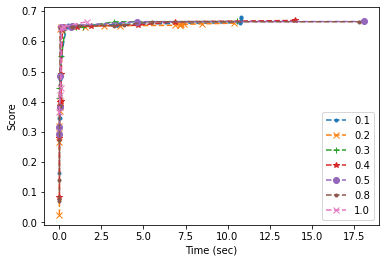

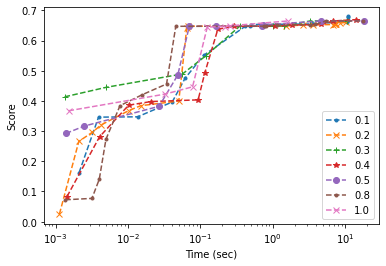

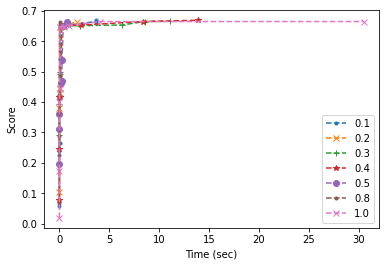

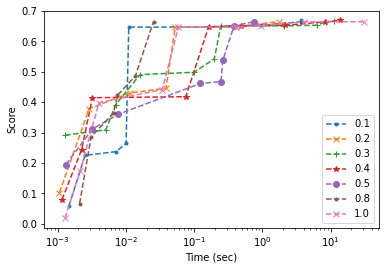

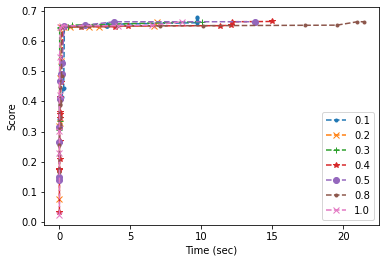

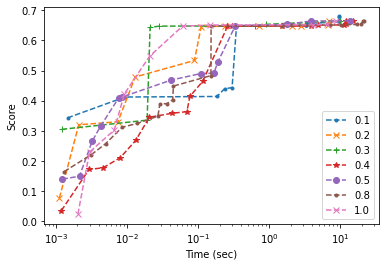

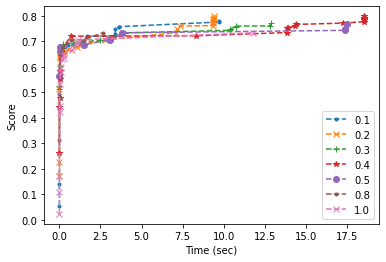

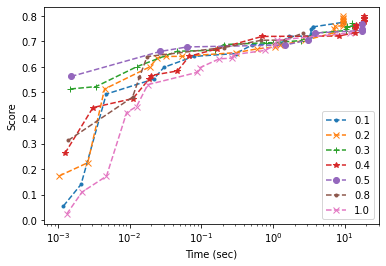

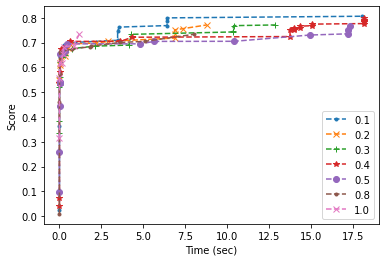

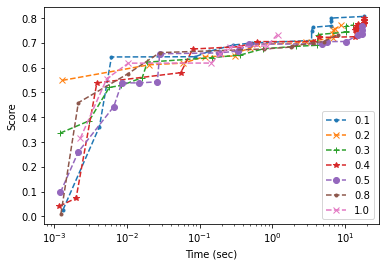

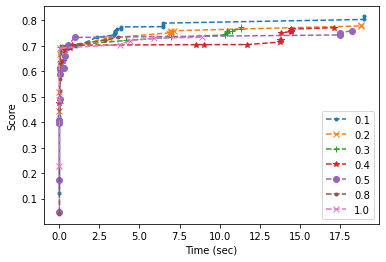

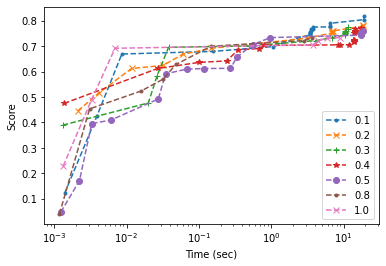

In [10]:
anytime()

In [11]:
prefix = 'ExpAll_'


methods = [
    {
        'name': 'ExpAll',
        'label': '0.1',
        'config':{
            'seeds_ratio': 0.1
        }, 
    },
    {
        'name': 'ExpAll',
        'label': '0.2',
        'config':{
            'seeds_ratio': 0.2
        }, 
    },
    {
        'name': 'ExpAll',
        'label': '0.3',
        'config':{
            'seeds_ratio': 0.3
        }, 
    },
    {
        'name': 'ExpAll',
        'label': '0.5',
        'config':{
            'seeds_ratio': 0.5
        }, 
    },
    {
        'name': 'ExpAll',
        'label': '1.0',
        'config':{
            'seeds_ratio': 1
        }, 
    },
]


# entropy_mode: low
## eps
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: ExpAll 0.1
0.6648784795648808 13.40768837928772 0.0030601024627685547 0.8215985298156738 1.2597129344940186
Run method: ExpAll 0.2
0.6604164536522855 20.00347137451172 0.005007266998291016 0.08171987533569336 0.6636748313903809
Run method: ExpAll 0.3
0.6517950584515437 20.013384103775024 0.01047205924987793 1.3447158336639404 2.4940900802612305
Run method: ExpAll 0.5
0.6648784795648808 20.032329082489014 0.009979724884033203 4.837762832641602 8.686268091201782
Run method: ExpAll 1.0
0.6648784795648808 25.78267478942871 0.016216278076171875 2.928393602371216 18.025904178619385

## max_size
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: ExpAll 0.1
0.6517950584515437 13.508464336395264 0.003695964813232422 0.12368535995483398 0.8956911563873291
Run method: ExpAll 0.2
0.6604164536522855 20.004019498825073 0.0046923160552978516 4.083698749542236 4.997712850570679
Run method: ExpAll 0.

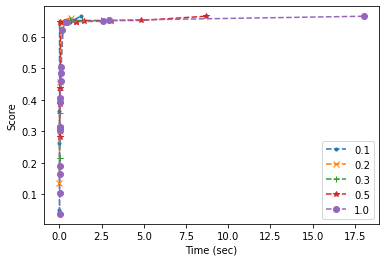

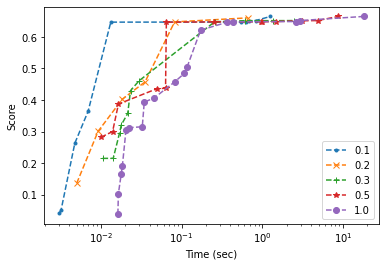

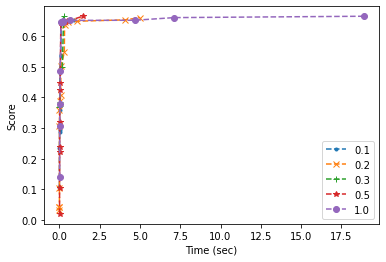

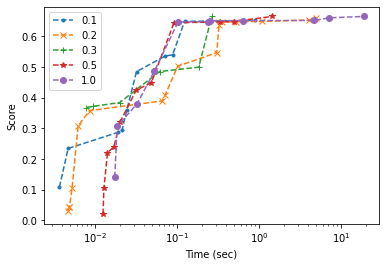

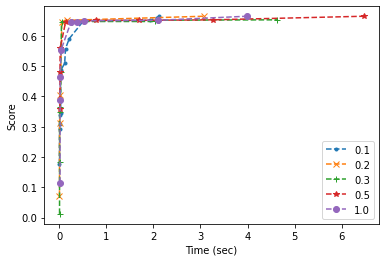

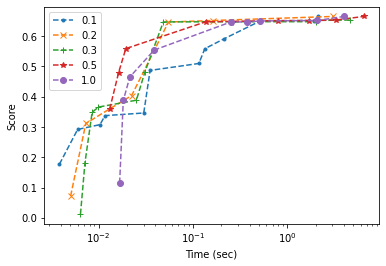

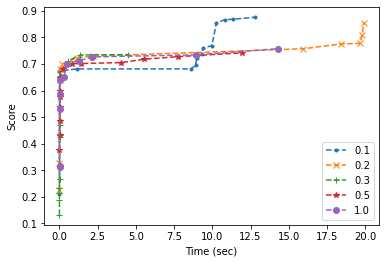

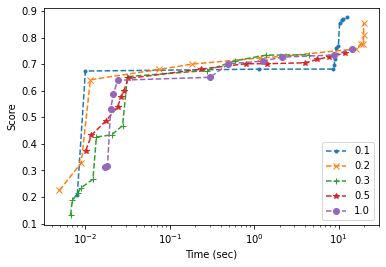

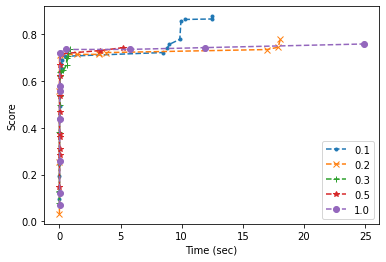

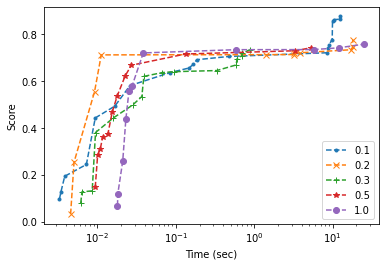

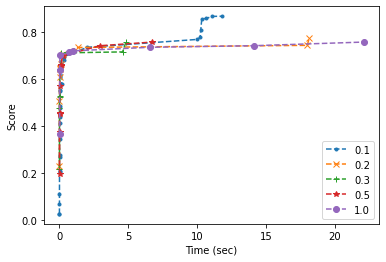

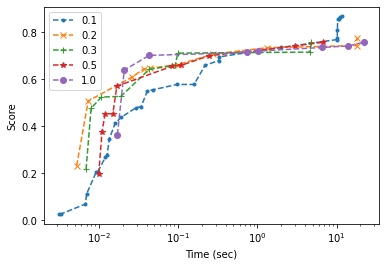

In [12]:
anytime()

In [13]:
prefix = 'ExpSingle_'


methods = [
    {
        'name': 'ExpSingle',
        'label': '0.1',
        'config':{
            'seeds_ratio': 0.1
        }, 
    },
    {
        'name': 'ExpSingle',
        'label': '0.2',
        'config':{
            'seeds_ratio': 0.2
        }, 
    },
    {
        'name': 'ExpSingle',
        'label': '0.3',
        'config':{
            'seeds_ratio': 0.3
        }, 
    },
    {
        'name': 'ExpSingle',
        'label': '0.5',
        'config':{
            'seeds_ratio': 0.5
        }, 
    },
    {
        'name': 'ExpSingle',
        'label': '1.0',
        'config':{
            'seeds_ratio': 1
        }, 
    },
]

# entropy_mode: low
## eps
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: ExpSingle 0.1
0.6691343022891632 20.14362645149231 0.006063699722290039 2.5246901512145996 2.7674572467803955
Run method: ExpSingle 0.2
0.6694764012532041 20.211833238601685 0.0068950653076171875 5.021931171417236 6.829881906509399
Run method: ExpSingle 0.3
0.6691343022891632 20.074658632278442 0.006196260452270508 8.422305345535278 8.664262056350708
Run method: ExpSingle 0.5
0.6694764012532041 20.265664100646973 0.009315013885498047 12.870604515075684 16.020623922348022
Run method: ExpSingle 1.0
0.6648784795648808 25.696680784225464 0.0162656307220459 0.4070472717285156 3.465287685394287

## max_size
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: ExpSingle 0.1
0.6691343022891632 20.062680959701538 0.003259897232055664 3.6323161125183105 3.868622303009033
Run method: ExpSingle 0.2
0.6694764012532041 20.214927196502686 0.0059964656829833984 1.3569927215576172 6.571110725402832
Run

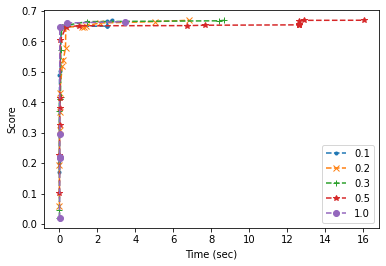

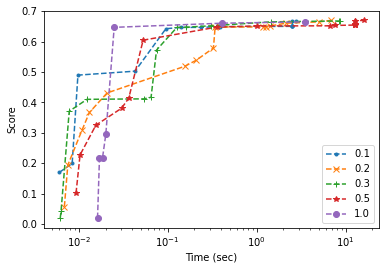

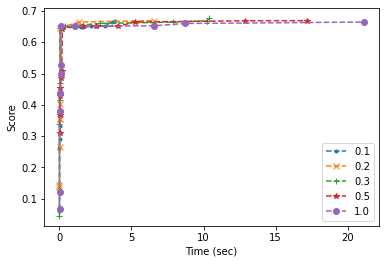

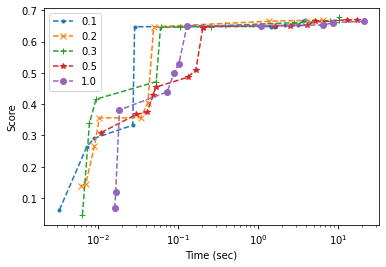

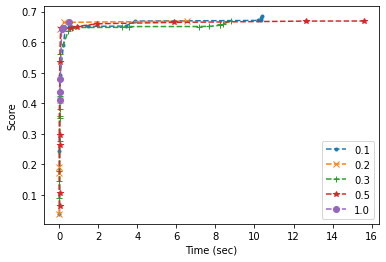

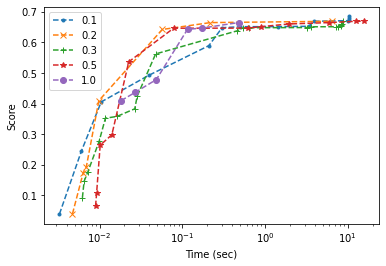

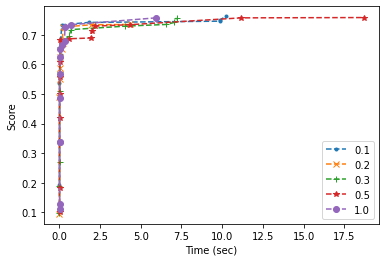

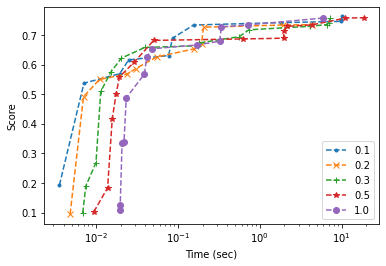

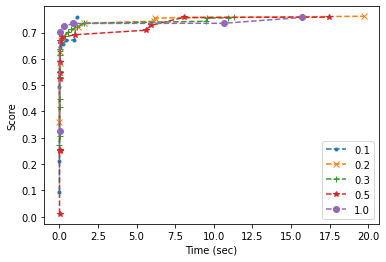

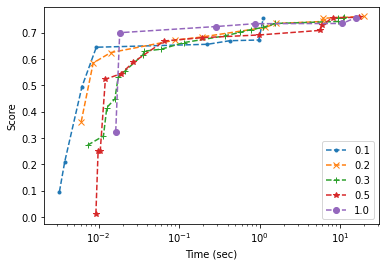

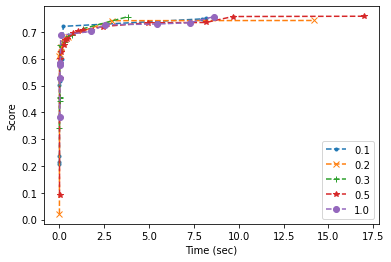

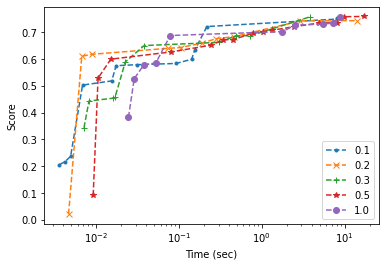

In [14]:
anytime()

In [15]:
prefix = 'ExpHybrid_'


methods = [
    {
        'name': 'ExpHybrid',
        'label': '0.01',
        'config':{
            'seeds_ratio': 0.01
        }, 
    },
    {
        'name': 'ExpHybrid',
        'label': '0.02',
        'config':{
            'seeds_ratio': 0.02
        }, 
    },
    {
        'name': 'ExpHybrid',
        'label': '0.03',
        'config':{
            'seeds_ratio': 0.03
        }, 
    },
    {
        'name': 'ExpHybrid',
        'label': '0.05',
        'config':{
            'seeds_ratio': 0.05
        }, 
    },
    {
        'name': 'ExpHybrid',
        'label': '0.06',
        'config':{
            'seeds_ratio': 0.06
        }, 
    },
    {
        'name': 'ExpHybrid',
        'label': '0.08',
        'config':{
            'seeds_ratio': 0.08
        }, 
    },
    {
        'name': 'ExpHybrid',
        'label': '0.1',
        'config':{
            'seeds_ratio': 0.1
        }, 
    },
]

# entropy_mode: low
## eps
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: ExpHybrid 0.01
0.6694764012532041 20.08066415786743 0.0018024444580078125 1.3945856094360352 1.9305975437164307
Run method: ExpHybrid 0.02
0.6694764012532041 20.075935125350952 0.001695871353149414 2.7748379707336426 3.3081376552581787
Run method: ExpHybrid 0.03
0.6694764012532041 20.19127321243286 0.001979351043701172 4.203984975814819 4.742137908935547
Run method: ExpHybrid 0.05
0.6694764012532041 20.234296321868896 0.00212860107421875 6.772307872772217 7.311941385269165
Run method: ExpHybrid 0.06
0.6694764012532041 20.223479747772217 0.002324819564819336 8.1728675365448 8.703906774520874
Run method: ExpHybrid 0.08
0.6694764012532041 20.103654861450195 0.002592802047729492 10.953580379486084 11.490752458572388
Run method: ExpHybrid 0.1
0.6694764012532041 20.194981575012207 0.0030143260955810547 13.771470546722412 14.306398630142212

## max_size
eps:0.003
max_size:200
size_weight:1
time_budget:2

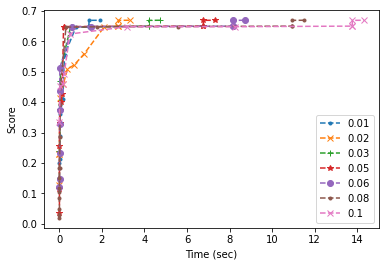

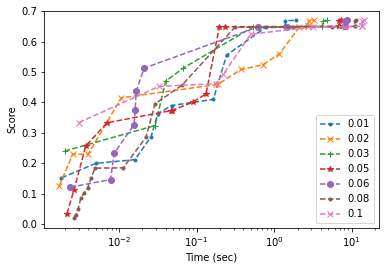

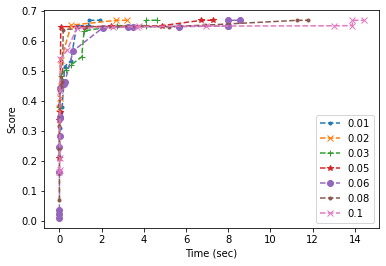

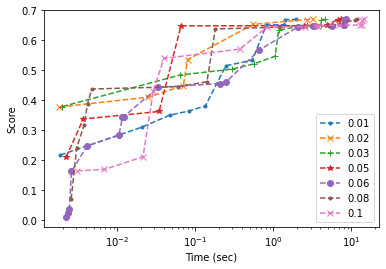

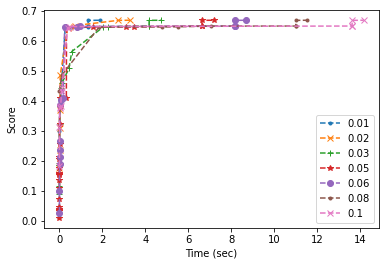

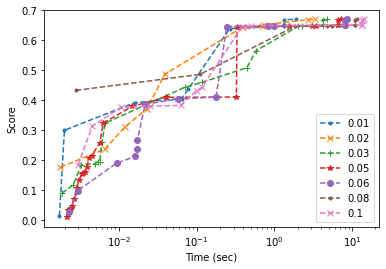

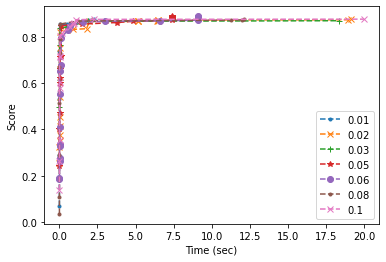

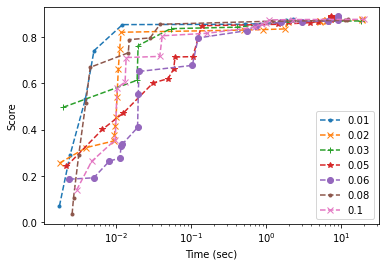

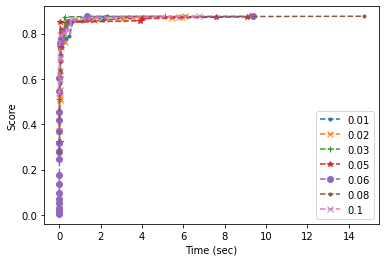

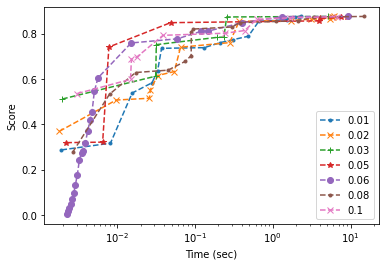

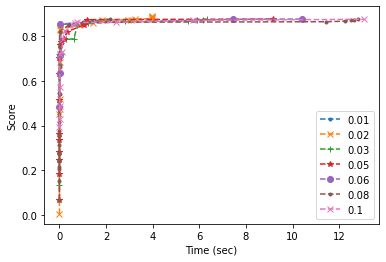

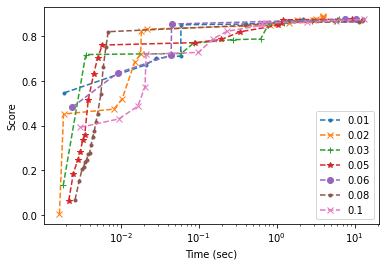

In [16]:
anytime()

In [17]:
prefix = 'Grid_S_'


methods = [
    {
        'name': 'Grid-S',
        'label': 'S-40/20',
        'config': {
            'top_gran': 40,
            'bot_gran': 10,
            'n_grids': 20,
            'n_top_samples': 1000,
            'n_bot_samples': 100000,
        },
    },
    {
        'name': 'Grid-S',
        'label': 'S-40/10',
        'config': {
            'top_gran': 40,
            'bot_gran': 10,
            'n_grids': 10,
            'n_top_samples': 1000,
            'n_bot_samples': 100000,
        },
    },
    {
        'name': 'Grid-S',
        'label': 'S-30/20',
        'config': {
            'top_gran': 30,
            'bot_gran': 10,
            'n_grids': 20,
            'n_top_samples': 1000,
            'n_bot_samples': 100000,
        },
    },
    {
        'name': 'Grid-S',
        'label': 'S-30/10',
        'config': {
            'top_gran': 30,
            'bot_gran': 10,
            'n_grids': 10,
            'n_top_samples': 1000,
            'n_bot_samples': 100000,
        },
    },
    {
        'name': 'Grid-S',
        'label': 'S-20/20',
        'config': {
            'top_gran': 20,
            'bot_gran': 10,
            'n_grids': 20,
            'n_top_samples': 1000,
            'n_bot_samples': 100000,
        },
    },
    {
        'name': 'Grid-S',
        'label': 'S-20/10',
        'config': {
            'top_gran': 20,
            'bot_gran': 10,
            'n_grids': 10,
            'n_top_samples': 1000,
            'n_bot_samples': 100000,
        },
    },
]

# entropy_mode: low
## eps
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: Grid-S S-40/20
0.6563686256760796 20.11050844192505 0.05598616600036621 1.1951522827148438 1.1971156597137451
Run method: Grid-S S-40/10
0.7004208930816068 20.040709495544434 0.049622535705566406 1.0701470375061035 1.0703058242797852
Run method: Grid-S S-30/20
0.6691343022891632 20.065231323242188 0.03504681587219238 10.661816596984863 18.948795795440674
Run method: Grid-S S-30/10
0.6528370399766086 20.0616557598114 0.03405261039733887 5.42906379699707 5.43274998664856
Run method: Grid-S S-20/20
0.6563686256760796 20.1650128364563 0.02317976951599121 8.834845781326294 8.846882104873657
Run method: Grid-S S-20/10
0.6771419581409757 20.04261827468872 0.02275228500366211 3.3816092014312744 3.382307291030884

## max_size
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: Grid-S S-40/20
0.6566999140154877 20.109165906906128 0.0515751838684082 4.663278341293335 4.66353964805603
Run method:

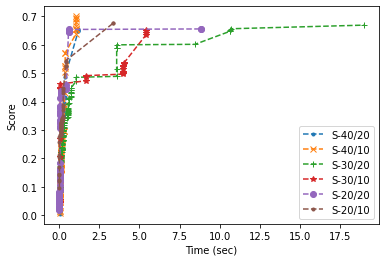

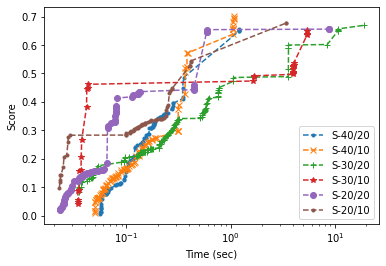

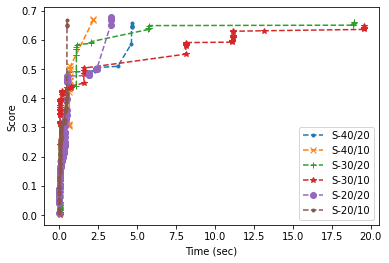

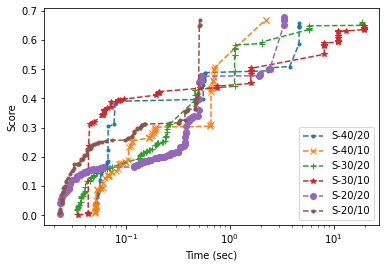

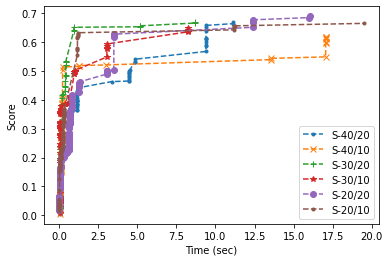

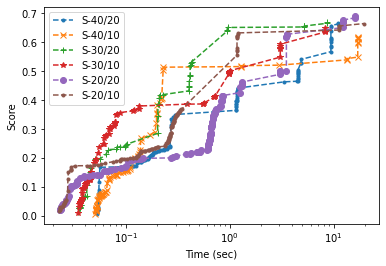

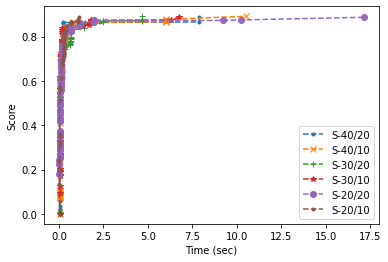

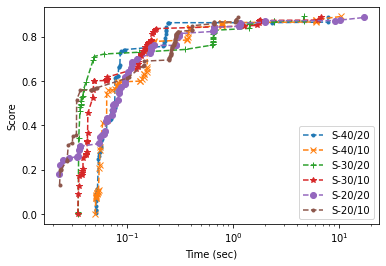

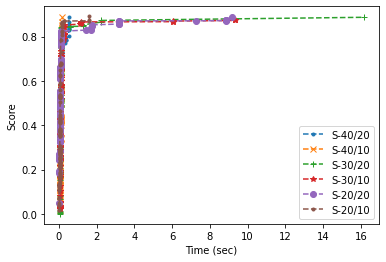

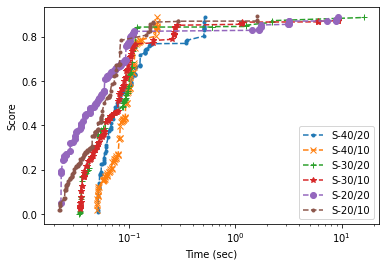

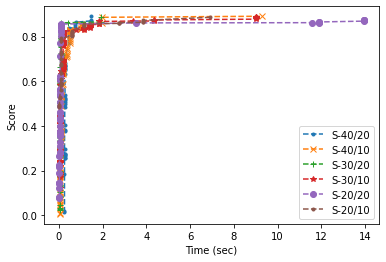

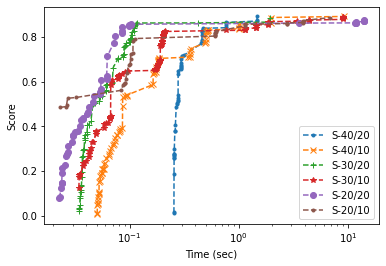

In [18]:
anytime()

# Experiments

## Low mixture

In [21]:
####### BEST for LOW at time_budget=~20, size_weight=1, max_size=200
entropy_modes = ['low']

variables = {
    'eps': {
        'range': [0.003], #[0.001, 0.002, 0.003], 
        'default': 0.003,
    },
    'max_size': {
        'range': [100, 200, 300],
        'default': 200,
    },
    'size_weight': {
        'range': [0, 0.5, 1, 2],
        'default': 1,
    },
    'time_budget': {
        'range': [],
        'default':20,
    },
}




methods = [
    {
        'name': 'ExpCircles',
        'label': 'CS',
        'config':{
            'seeds_ratio': 0.2
        }, 
    },
    {
        'name': 'ExpAll',
        'label': 'GA',
        'config':{
            'seeds_ratio': 0.5
        }, 
    },
    {
        'name': 'ExpSingle',
        'label': 'GB',
        'config':{
            'seeds_ratio': 0.2
        },
    },
    {
        'name': 'ExpHybrid',
        'label': 'GH',
        'config':{
            'seeds_ratio': 0.02
        },
    },
    {
        'name': 'Grid-S',
        'label': 'GG',
        'config': {
            'top_gran': 20,
            'bot_gran': 10,
            'n_grids': 20,
            'n_top_samples': 1000,
            'n_bot_samples': 100000,
        },
    }
]

# entropy_mode: low
## max_size
eps:0.003
max_size:100
size_weight:1
time_budget:20
Run method: CS
0.6458012321569845 20.009243488311768
Run method: GA
0.6302034307426657 20.005833466847736
Run method: GB
0.7327363458165063 20.049795627593994
Run method: GH
0.5842221025405995 20.00400463740031
Run method: GG
0.7007503339282323 20.006714979807537

eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: CS
0.663601723921786 20.017034371693928
Run method: GA
0.6603876786700066 20.026347398757935
Run method: GB
0.6719175538944476 20.157814025878906
Run method: GH
0.6694764012532041 20.13049880663554
Run method: GG
0.6649582377120083 20.139276663462322

eps:0.003
max_size:300
size_weight:1
time_budget:20
Run method: CS
0.5653253843572581 20.030021905899048
Run method: GA
0.5611020930274665 20.036168654759724
Run method: GB
0.5922466736895039 20.171586831410725
Run method: GH
0.6018648470827599 20.1065620581309
Run method: GG
0.5952307369999388 20.13392925262451

## size_weight
eps:0

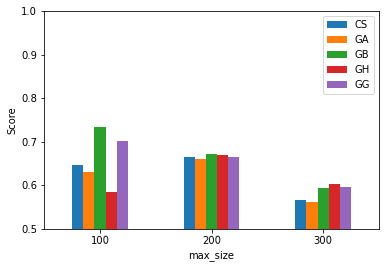

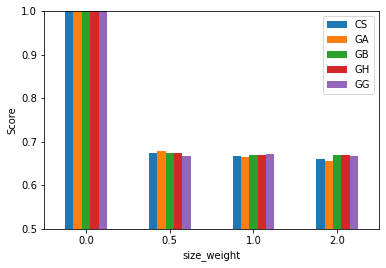

In [22]:
box_plots()

# entropy_mode: low
## eps
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: ExpCircles CS
0.6648177093743933 20.019537925720215 0.001028299331665039 0.690342903137207 1.2748684883117676
Run method: ExpAll GA
0.6648784795648808 20.02896738052368 0.010105609893798828 0.5136809349060059 3.5492467880249023
Run method: ExpSingle GB
0.6771419581409757 20.043368816375732 0.0059664249420166016 5.684075832366943 5.847752571105957
Run method: ExpHybrid GH
0.6694764012532041 20.079258680343628 0.001947164535522461 2.7192542552948 3.2611894607543945
Run method: Grid-S GG
0.6771419581409757 20.1150906085968 0.02413654327392578 10.336654663085938 10.337351322174072

## max_size
eps:0.003
max_size:100
size_weight:1
time_budget:20
Run method: ExpCircles CS
0.6863670047477113 20.009520530700684 0.0012257099151611328 5.47349214553833 5.915982007980347
Run method: ExpAll GA
0.767137688080326 20.00619077682495 0.009319067001342773 0.1251850128173828 1.3682997226715088
Run method: ExpSingle 

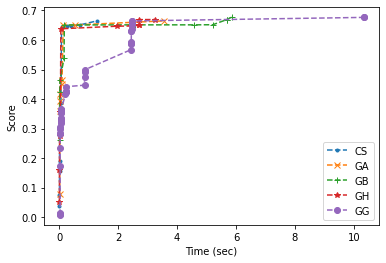

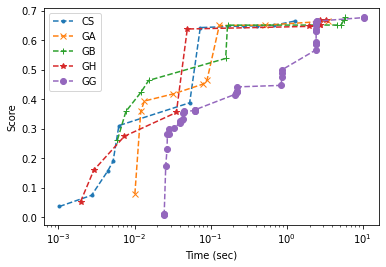

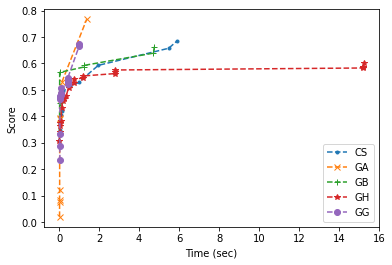

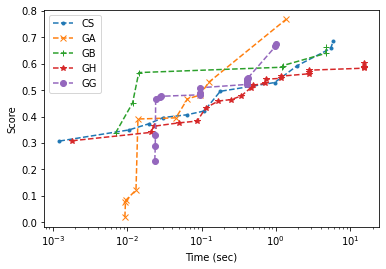

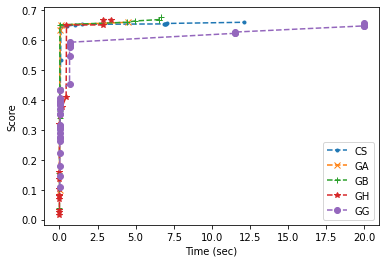

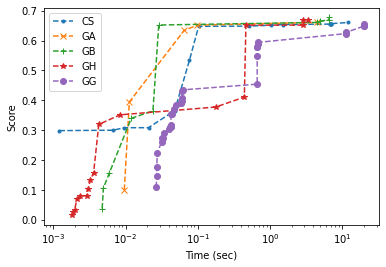

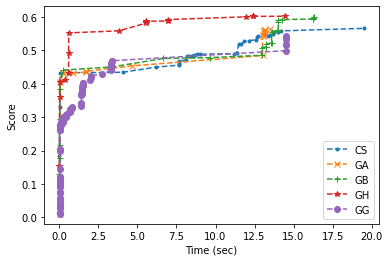

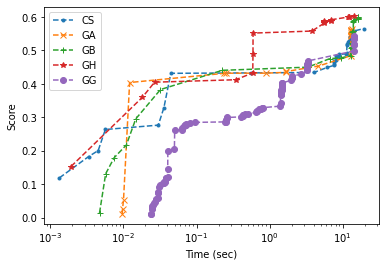

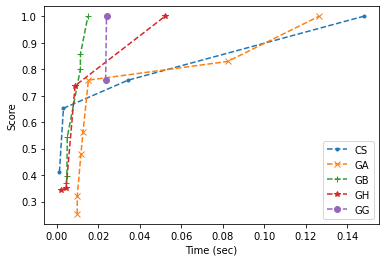

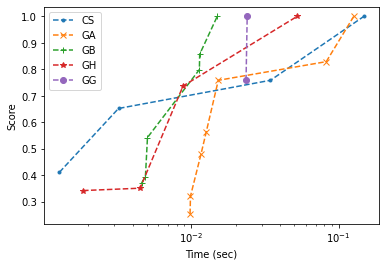

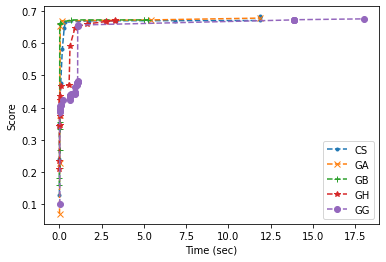

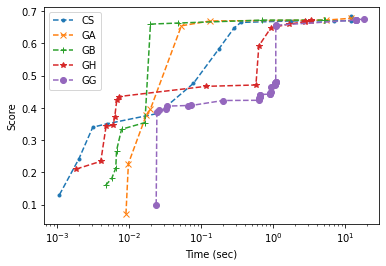

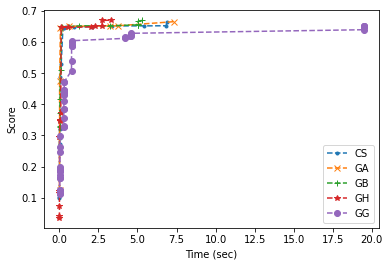

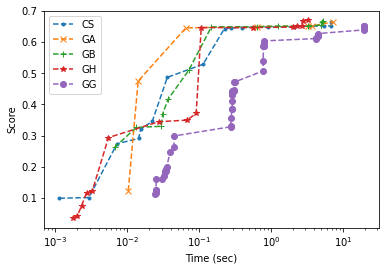

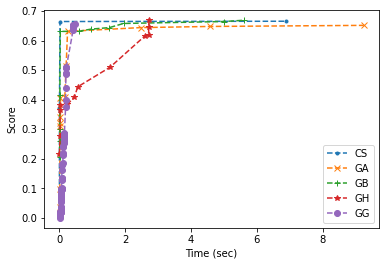

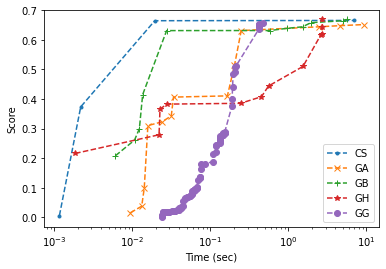

In [23]:
prefix = 'cmp_'
anytime()

## High mixture

In [7]:
####### BEST for HIGH at time_budget=~20, size_weight=1, max_size=200
entropy_modes = ['high']


variables = {
    'eps': {
        'range': [0.003], #[0.001, 0.002, 0.003], 
        'default': 0.003,
    },
    'max_size': {
        'range': [100, 200, 300],
        'default': 200,
    },
    'size_weight': {
        'range': [0, 0.5, 1, 2],
        'default': 1,
    },
    'time_budget': {
        'range': [],
        'default':20,
    },
}


methods = [
    {
        'name': 'ExpCircles',
        'label': 'CS',
        'config':{
            'seeds_ratio': 0.1
        }, 
    },
    {
        'name': 'ExpAll',
        'label': 'GA',
        'config':{
            'seeds_ratio': 0.3
        }, 
    },
    {
        'name': 'ExpSingle',
        'label': 'GB',
        'config':{
            'seeds_ratio': 0.1
        },
    },
    {
        'name': 'ExpHybrid',
        'label': 'GH',
        'config':{
            'seeds_ratio': 0.03
        },
    },
    {
        'name': 'Grid-S',
        'label': 'GG',
        'config': {
            'top_gran': 20,
            'bot_gran': 10,
            'n_grids': 20,
            'n_top_samples': 1000,
            'n_bot_samples': 100000,
        },
    },
]

# entropy_mode: high
## max_size
eps:0.003
max_size:100
size_weight:1
time_budget:20
Run method: CS
0.8746970014939381 20.00701141357422
Run method: GA
0.875942012823927 15.574233849843344
Run method: GB
0.8364524430423709 20.02682137489319
Run method: GH
0.9023545226172461 20.003550450007122
Run method: GG
0.9052165513191585 20.01198895772298

eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: CS
0.7721027235124955 20.00793234507243
Run method: GA
0.7319820894772558 20.01562253634135
Run method: GB
0.7605484505833547 20.24581281344096
Run method: GH
0.8836692595855711 20.01330852508545
Run method: GG
0.8882593243935707 20.079304297765095

eps:0.003
max_size:300
size_weight:1
time_budget:20
Run method: CS
0.7316836184081653 20.014323234558105
Run method: GA
0.6397313672133836 20.017549355824787
Run method: GB
0.684759846165769 20.449756383895874
Run method: GH
0.8839080372356928 20.019747972488403
Run method: GG
0.8879162372505495 20.372947692871094

## size_weight
eps:0.0

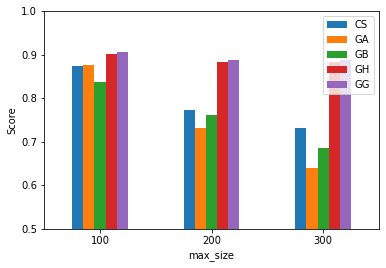

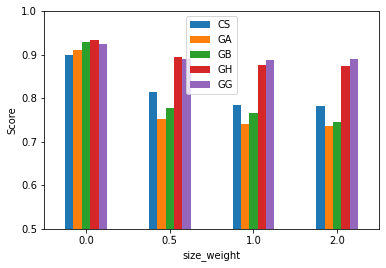

In [25]:
box_plots()

# entropy_mode: high
## eps
eps:0.003
max_size:200
size_weight:1
time_budget:20
Run method: ExpCircles CS
0.7828952340677398 20.010281085968018 0.0010905265808105469 9.963395595550537 19.73082423210144
Run method: ExpAll GA
0.7102066021203801 20.012325763702393 0.006668806076049805 1.157557487487793 4.169080495834351
Run method: ExpSingle GB
0.7618825662258811 20.24647045135498 0.0029692649841308594 7.597427606582642 16.022220134735107
Run method: ExpHybrid GH
0.8731907999707079 20.037817239761353 0.0019326210021972656 16.254291772842407 16.276010751724243
Run method: Grid-S GG
0.8866778544608307 20.117817401885986 0.023892641067504883 1.6442558765411377 6.571660041809082

## max_size
eps:0.003
max_size:100
size_weight:1
time_budget:20
Run method: ExpCircles CS
0.8762359382244005 20.00403141975403 0.002603292465209961 18.155349731445312 18.15788435935974
Run method: ExpAll GA
0.8725619089488075 15.369895219802856 0.0076961517333984375 10.88616132736206 10.988391160964966
Run method: Ex

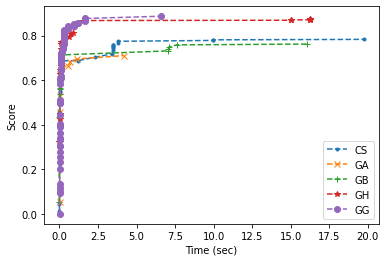

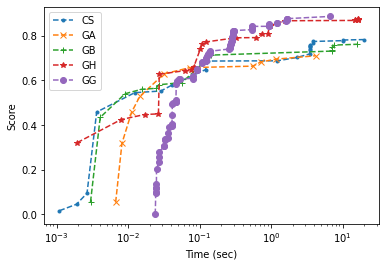

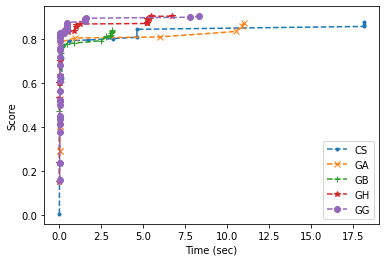

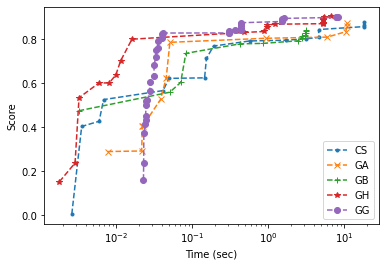

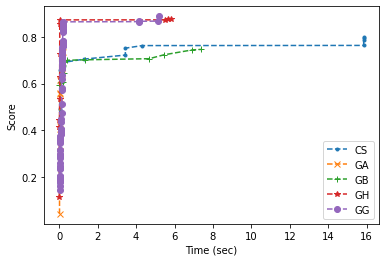

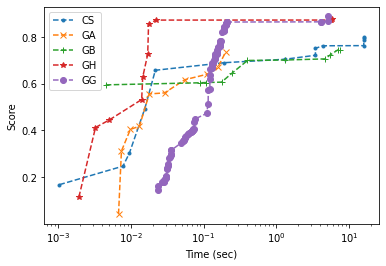

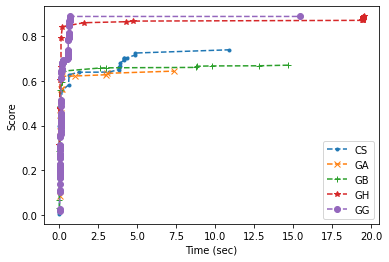

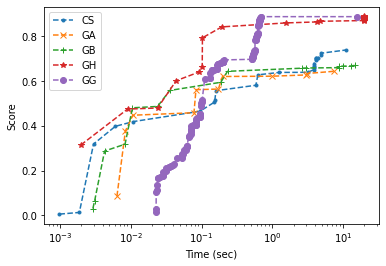

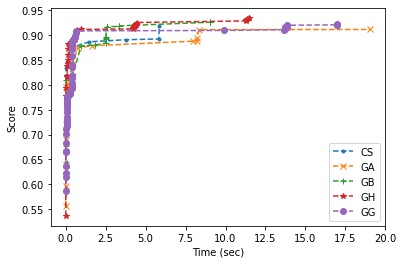

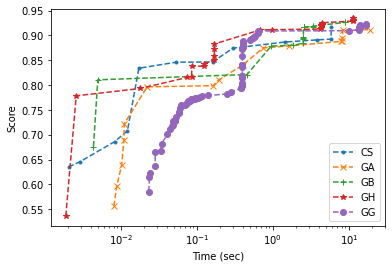

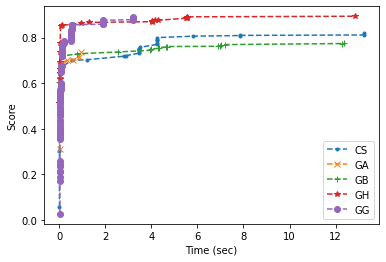

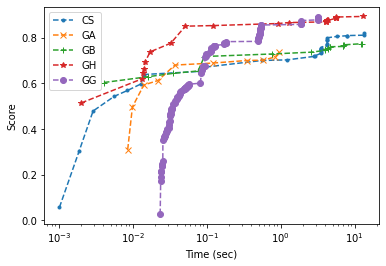

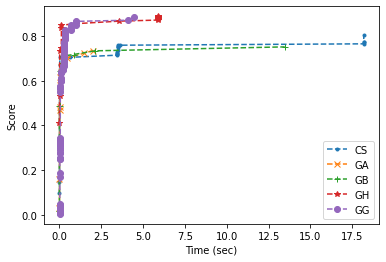

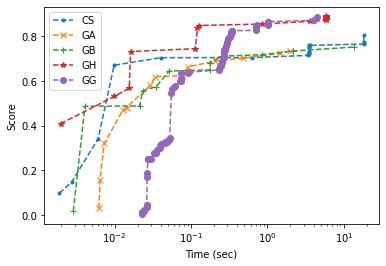

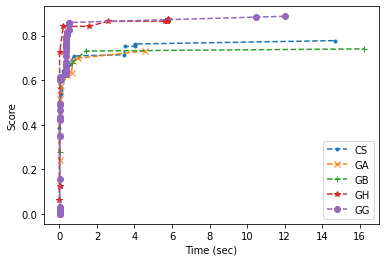

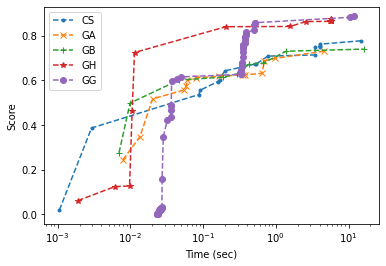

In [12]:
prefix = 'cmp_'
anytime()